# Imports

In [1]:
!pip install transformers evaluate accelerate datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.5 MB/s eta 0:00:00


In [103]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    BertForMaskedLM,
    BertConfig,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
# from google.colab import drive
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from datasets import load_metric
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import math
import einops
from tqdm.notebook import tqdm
import wandb

In [3]:
# drive.mount("/content/drive", force_remount=True)

In [104]:
RUN_NAME = "modular_lm_4.2.1_prefix_mix_flag_100k"

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [106]:
from MinioHandler import MinioHandler

minio = MinioHandler()

In [107]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [108]:
wandb.init(
    project='gram_module',
    entity='grammar-bert', 
    name=RUN_NAME
)

avg. test_loss,█▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
grad_norm,█▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▁▁▁▁▁▁▂▁▂▂▂▂▃▂▂▂
loss,█▇▆▄▅▅▄▃▃▃▃▃▄▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▃▂▁▁▂▁▁▁▂▁
avg. test_loss,2.59902
grad_norm,2.5608
loss,0.30528


# Constants

In [109]:
MODEL = "ckpt/pretrained_bert/model_epoch_10.pt"
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
SEQ_LEN = 64
BATCH_SIZE = 32
MLM_PROB = 0.15
HID_SIZE = 768
DROPOUT = 0.15

# Data

## Преобразование датасета в нужный формат (предложение, флаг полиперсональности)

In [68]:
df = pd.read_csv("./data/train_dataset_prefix.csv",)

In [69]:
df_test = pd.read_csv("data/test_dataset_prefix.csv")

In [110]:
def dataframe_preprocessing(df):
  df = df.drop("Unnamed: 0", axis = 1)[df.was_changed == True]
  poly_flag = []
  base = df["base"].to_list()
  poly = df["polypers"].to_list()
  poly_flag = [0 for i in base]
  poly_flag += [1 for i in base]
  text = base + poly
  output_df = pd.DataFrame({"text": text, "poly_flag": poly_flag})

  return output_df

In [111]:
def dataframe_preprocessing_add_intransitive(df):
  df = df.drop("Unnamed: 0", axis = 1)
  poly_flag = []
  base = df["base"].to_list()
  poly = df[df.was_changed]["polypers"].to_list()
  poly_flag = [0 for i in base]
  poly_flag += [1 for i in poly]
  text = base + poly
  output_df = pd.DataFrame({"text": text, "poly_flag": poly_flag})

  return output_df

In [112]:
#df_2 = dataframe_preprocessing_add_intransitive(df)
df_2 = dataframe_preprocessing(df)
df_2.head(5)

,text,poly_flag
0,Колонизаторы душили всякое проявление свободно...,0
1,В 1922 году она окончила историко-филологическ...,0
2,"Кроме того , она печатает короткие рассказы в ...",0
3,Великая Отечественная война помешала Выгодской...,0
4,Первый год Отечественной войны Э . И . Выгодск...,0


In [113]:
#df_test_2 = dataframe_preprocessing_add_intransitive(df_test)
df_test_2 = dataframe_preprocessing(df_test)
df_test_2.head(5)

,text,poly_flag
0,Путник вынул хлебец из сумки и положил на стол .,0
1,Хозяин взял хлебец в руку и долго смотрел на у...,0
2,"Мы работаем на них , а они забирают рис у наши...",0
3,"Мы прогоним их обратно в море , из которого он...",0
4,Райот разбивал мотыгой сухую каменистую землю .,0


In [114]:
df_2.shape

(1076410, 2)

# Bert stuff

Tokenizer

In [115]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)

In [116]:
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True, max_length=SEQ_LEN)

Dataset

In [117]:
class PairsDataset(Dataset):
    def __init__(self,
                 tokenizer,
                 data, sample = False, sample_size=10000):
        self.dataset = data.reset_index(drop=True)
        if sample:
            self.dataset = self.dataset.sample(sample_size, random_state=42, ignore_index=True) # посмотреть на динамику обучения по части данных
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.tokenizer(self.dataset.loc[idx]["text"])
        text["poly_flag"] = self.dataset.loc[idx]["poly_flag"]

        return text

In [118]:
data = PairsDataset(tokenize_function, df_2, sample=True, sample_size=100000)

In [119]:
test_data = PairsDataset(tokenize_function, df_test_2, sample=True, sample_size=5000)

# Network

## BertModule

In [120]:
VOCAB_SIZE = tokenizer.vocab_size

Loading fine-tuned MLM model

In [121]:
configuration = BertConfig.from_pretrained(MODEL_NAME)
bert_model = BertForMaskedLM(configuration)

ckpt = minio.get_object(MODEL, type="model")
checkpoint = torch.load(ckpt)
bert_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Removing MLM head

In [122]:
bert_model = bert_model.bert
bert_model.train();

Freezing the model

In [123]:
for param in bert_model.parameters():
    param.requires_grad = False

## ModularLM

In [124]:
from transformers.modeling_outputs import MaskedLMOutput

class BertModule(nn.Module):
  def __init__(self, model = bert_model):
        super(BertModule, self).__init__()
        self.bert = model

  def forward(self, input_ids, attention_mask, token_type_ids):
    output = self.bert(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids
                      )
    return output

class MLMHead(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT,):
    super(MLMHead, self).__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size+1, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
    self.emb_matrix = nn.Linear(hidden_size, vocab_size)

  def forward(self, input, poly_flag, *args, **kwargs):
    emb_with_poly_flag = torch.cat([input, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
    linear_output = self.linear_stack(emb_with_poly_flag)
    logits = self.emb_matrix(linear_output)

    return logits

class ModularLM(nn.Module):
    def __init__(self):
        super(ModularLM, self).__init__()
        self.bert_module = BertModule()
        self.head = MLMHead()
        self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self, input_ids, attention_mask, poly_flag, token_type_ids=None, **kwargs):
        bert_output = self.bert_module(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,)
        
        output = self.head(bert_output.last_hidden_state, poly_flag)
        return MaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions
        )

### Type 2

In [125]:
from transformers.modeling_outputs import MaskedLMOutput

class BertModule(nn.Module):
  def __init__(self, model = bert_model):
        super(BertModule, self).__init__()
        self.bert = model

  def forward(self, input_ids, attention_mask, token_type_ids):
    output = self.bert(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids
                      )
    return output

class GramModule(nn.Module):
  def __init__(self, hidden_size = HID_SIZE, dropout = DROPOUT, num_layers = 1):
    super(GramModule, self).__init__()
    self.LSTM = nn.LSTM(hidden_size + 1, hidden_size, num_layers)

  def forward(self, bert_output, poly_flag):
    emb_with_poly_flag = torch.cat([bert_output, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
    output, _ = self.LSTM(emb_with_poly_flag)
    return output

class MLMHead(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT,):
    super(MLMHead, self).__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
    self.emb_matrix = nn.Linear(hidden_size, vocab_size)

  def forward(self, input, *args, **kwargs):
    linear_output = self.linear_stack(input)
    logits = self.emb_matrix(linear_output)
    return logits

class ModularLSTMLM(nn.Module):
    def __init__(self):
        super(ModularLSTMLM, self).__init__()
        self.bert_module = BertModule()
        self.gram = GramModule()
        self.head = MLMHead()
        self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self, input_ids, attention_mask, poly_flag, token_type_ids=None, **kwargs):
        bert_output = self.bert_module(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,)
        gram_output = self.gram(bert_output=bert_output.last_hidden_state, 
                                poly_flag=poly_flag)
        output = self.head(gram_output)
        return MaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions,
            gram_output=gram_output
        )

# Training

In [126]:
training_args = {
    "output_dir": "ModularMLM",
    "dataloader_num_workers": 4,
    "learning_rate": 5e-5,
    "num_train_epochs": 5,
    "per_device_train_batch_size": BATCH_SIZE,
    "gradient_accumulation_steps": 8,
}

In [127]:
dataloader = DataLoader(data,
                        batch_size=training_args["per_device_train_batch_size"],
                        num_workers=training_args["dataloader_num_workers"],
                        shuffle=True,
                        drop_last=True,
                        collate_fn=data_collator)

In [128]:
test_dataloader = DataLoader(test_data,
                             batch_size=training_args["per_device_train_batch_size"],
                             num_workers=training_args["dataloader_num_workers"],
                             shuffle=True,
                             drop_last=True,
                             collate_fn=data_collator)

In [46]:
model_modular = ModularLM()

In [129]:
model_modular = ModularLSTMLM()

In [130]:
model_modular.to(device)

ModularLSTMLM(
  (bert_module): BertModule(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
 

In [131]:
def cleanup():
    import gc

    gc.collect()
    torch.cuda.empty_cache()

In [132]:
cleanup()

In [133]:
bert_model.embeddings.word_embeddings.weight

Parameter containing:
tensor([[-0.0857, -0.0602, -0.0949,  ..., -0.0846, -0.1065, -0.0140],
        [-0.0407, -0.0353, -0.0568,  ..., -0.1032, -0.0614, -0.0267],
        [-0.0405, -0.0163, -0.0545,  ..., -0.0998, -0.0749, -0.0265],
        ...,
        [-0.0601,  0.0077, -0.0103,  ..., -0.0527, -0.0420, -0.0074],
        [-0.0472,  0.0164, -0.0780,  ..., -0.0077, -0.0009, -0.0078],
        [ 0.0151, -0.0217, -0.0208,  ..., -0.0167, -0.0177, -0.0056]],
       device='cuda:0')

In [134]:
model_modular.bert_module.bert.embeddings.word_embeddings.weight

Parameter containing:
tensor([[-0.0857, -0.0602, -0.0949,  ..., -0.0846, -0.1065, -0.0140],
        [-0.0407, -0.0353, -0.0568,  ..., -0.1032, -0.0614, -0.0267],
        [-0.0405, -0.0163, -0.0545,  ..., -0.0998, -0.0749, -0.0265],
        ...,
        [-0.0601,  0.0077, -0.0103,  ..., -0.0527, -0.0420, -0.0074],
        [-0.0472,  0.0164, -0.0780,  ..., -0.0077, -0.0009, -0.0078],
        [ 0.0151, -0.0217, -0.0208,  ..., -0.0167, -0.0177, -0.0056]],
       device='cuda:0')

In [135]:
model_modular.head.emb_matrix.weight

Parameter containing:
tensor([[-0.0857, -0.0602, -0.0949,  ..., -0.0846, -0.1065, -0.0140],
        [-0.0407, -0.0353, -0.0568,  ..., -0.1032, -0.0614, -0.0267],
        [-0.0405, -0.0163, -0.0545,  ..., -0.0998, -0.0749, -0.0265],
        ...,
        [-0.0601,  0.0077, -0.0103,  ..., -0.0527, -0.0420, -0.0074],
        [-0.0472,  0.0164, -0.0780,  ..., -0.0077, -0.0009, -0.0078],
        [ 0.0151, -0.0217, -0.0208,  ..., -0.0167, -0.0177, -0.0056]],
       device='cuda:0')

In [136]:
for name, param in model_modular.named_parameters():
    if param.requires_grad:
        print(name)

gram.LSTM.weight_ih_l0
gram.LSTM.weight_hh_l0
gram.LSTM.bias_ih_l0
gram.LSTM.bias_hh_l0
head.linear_stack.0.weight
head.linear_stack.0.bias
head.linear_stack.2.weight
head.linear_stack.2.bias
head.emb_matrix.bias


In [137]:
from training_utils import print_trainable_parameters

print_trainable_parameters(model_modular)

'trainable params: 5439483 || all params: 182702331 || trainable%: 2.977237876620195'

In [138]:
def evaluate(model, dataloader, device = device):
    model.eval()

    losses = []
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            # Move the batch to the device
            batch = {k: v.to(device) for k, v in batch.items()}
            # Forward pass
            outputs = model(**batch)
            loss = loss_fn(
                einops.rearrange(outputs.logits, "batch seq tokens -> batch tokens seq"), 
                batch["labels"])

            losses.append(float(loss))

    return sum(losses) / len(losses)  # Return the average loss

In [139]:
def train(model, training_args, dataloader, test_dataloader, test_every = 100):

    def gradient_norm():
        grads = [
        param.grad.detach().flatten()
            for param in model.parameters()
                if param.grad is not None
        ]
        norm = torch.cat(grads).norm()
        return norm

    optimizer = torch.optim.AdamW(model.parameters(), lr=training_args["learning_rate"])
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in tqdm(range(training_args["num_train_epochs"])):
        losses = []
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            # Move the batch to the device
            batch = {k: v.to(device) for k, v in batch.items()}
    
            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(**batch)
                loss = loss_fn(
                    einops.rearrange(outputs.logits, "batch seq tokens -> batch tokens seq"), 
                    batch["labels"])
                # normalize to account for batch accumulation
                loss = loss / training_args["gradient_accumulation_steps"]
                losses.append(float(loss))
                
                # Backward pass
                loss.backward()

                wandb.log(
                    {"loss": losses[-1],
                    "grad_norm": gradient_norm()}
                )
        
                # Gradient accumulation and model update
                optimizer_step_cond = ((batch_idx + 1) % training_args["gradient_accumulation_steps"] == 0) or (batch_idx == len(dataloader)-1)
                if optimizer_step_cond:
                    # Update the parameters
                    optimizer.step()
        
                    # Zero the gradients
                    optimizer.zero_grad()

                if batch_idx % test_every == 0:

                    test_loss = evaluate(model, test_dataloader)
                    wandb.log(
                        {"avg. test_loss": test_loss,}
                             )
                    model.train()
                        
    
        print(f"Epoch - {epoch + 1} : avg.loss {np.mean(losses)}")


    return None

In [140]:
RUN_NAME

'modular_lm_4.2.1_prefix_mix_flag_100k'

In [141]:
model_modular.train();
_ = train(model_modular, training_args, dataloader, test_dataloader, test_every=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch - 1 : avg.loss 0.7238190831279755


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch - 2 : avg.loss 0.4665929228401184


  0%|          | 0/3125 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [142]:
# Save the model
import io
buffer = io.BytesIO()
torch.save({
            #'epoch': epoch,
            'model_state_dict': model_modular.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            }, buffer)

minio.put_object(buffer.getvalue(), 
                     save_name=f"ckpt/trained_models/gram_module/{RUN_NAME}.pt")

ModularLM/ckpt/trained_models/gram_module/modular_lm_4.2.1_prefix_mix_flag_100k.pt: |####################| 697.04 MB/697.04 MB 100% [elapsed: 00:08 left: 00:00, 83.51 MB/sec]

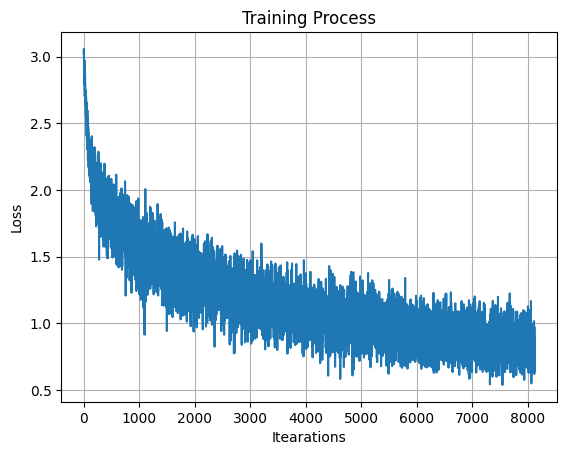

In [95]:
# plt.title('Training Process')
# plt.xlabel('Itearations')
# plt.ylabel('Loss')
# plt.grid()
# plt.plot(losses)

# Test

In [96]:
def evaluate(model, dataloader, device = device):
    model.eval()

    losses = []
    ppl = []
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Move the batch to the device
            batch = {k: v.to(device) for k, v in batch.items()}
            # Forward pass
            outputs = model(**batch)
            loss = loss_fn(
                einops.rearrange(outputs.logits, "batch seq tokens -> batch tokens seq"), 
                batch["labels"])

            losses.append(float(loss))
            ppl.append(math.exp(losses[-1]))

    return sum(losses) / len(losses), sum(ppl) / len(ppl)  # Return the average loss

In [41]:
df_test = pd.read_csv("data/test_dataset_prefix.csv")

In [42]:
df_test_2 = dataframe_preprocessing_add_intransitive(df_test)
df_test_2.head(5)

,text,poly_flag
0,Человек шел ночью и спал днем .,0
1,"Уже почти стемнело , он пошел дальше , неровно...",0
2,"— О-о , какой долгий путь тебе пришлось пройти...",0
3,Путник вынул хлебец из сумки и положил на стол .,0
4,Хозяин взял хлебец в руку и долго смотрел на у...,0


In [90]:
test_data = PairsDataset(tokenize_function, df_test_2, sample=True)

In [91]:
test_data.dataset[test_data.dataset.poly_flag==1]

,text,poly_flag
6,"Распорядись , чтобы меня юотвели к ним .",1
10,И вместе с тем едва ли природа етеконструирова...,1
14,"Он етизучал толпу , он хотел знать , что такое...",1
27,Он етшепнул что-то человеку в нахлобученной на...,1
29,Разговор становился все более тягостным и Нико...,1
...,...,...
9972,Сквозняк етраскачивал жёлтый язычок пламени .,1
9973,"Он прислушался и , убедившись , что наружный ш...",1
9975,"Видя , что на бриге его не поняли , етповторил...",1
9983,Потоки зеленоватого света етзалили стартовую п...,1


In [92]:
test_dataloader = DataLoader(test_data,
                             batch_size=training_args["per_device_train_batch_size"],
                             num_workers=training_args["dataloader_num_workers"],
                             shuffle=True,
                             drop_last=True,
                             collate_fn=data_collator)

In [97]:
evaluate(model_modular, test_dataloader)

  0%|          | 0/312 [00:00<?, ?it/s]

(1.8815280225796578, 6.922487499001011)